In [20]:
# Install required libraries
!pip install yfinance pandas numpy matplotlib plotly requests

# Fetching Stock Data

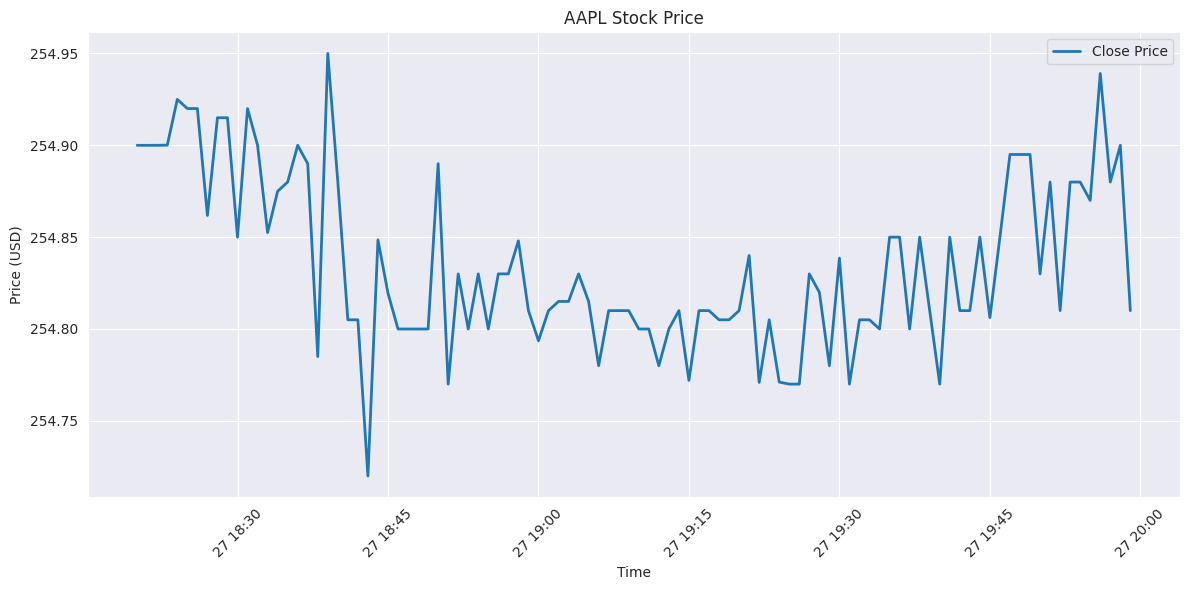

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class StockDataFetcher:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"

    def fetch_intraday_data(self, symbol, interval="1min"):
        params = {
            "function": "TIME_SERIES_INTRADAY",
            "symbol": symbol,
            "interval": interval,
            "apikey": self.api_key
        }

        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()

            data = response.json()

            if "Error Message" in data:
                return f"Error: {data['Error Message']}"
            elif "Note" in data:
                return f"API limit reached: {data['Note']}"

            time_series_key = f"Time Series ({interval})"
            if time_series_key not in data:
                return "Error: No time series data found"

            df = pd.DataFrame.from_dict(data[time_series_key], orient="index")
            df.columns = [col.split(". ")[1] for col in df.columns]
            df = df.astype(float)
            df.index = pd.to_datetime(df.index)

            return df

        except requests.exceptions.RequestException as e:
            return f"Network error: {str(e)}"
        except Exception as e:
            return f"Error processing data: {str(e)}"

    def plot_stock_data(self, df, symbol):
        plt.figure(figsize=(12, 6))
        sns.set_style("darkgrid")
        plt.plot(df.index, df['close'], label='Close Price', linewidth=2)
        plt.title(f'{symbol} Stock Price')
        plt.xlabel('Time')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    API_KEY = "68UGEXMTUAK8CGCF"
    fetcher = StockDataFetcher(API_KEY)

    symbol = "AAPL"
    stock_data = fetcher.fetch_intraday_data(symbol)

    if isinstance(stock_data, pd.DataFrame):
        fetcher.plot_stock_data(stock_data, symbol)
    else:
        print(f"Error: {stock_data}")

Trading Strategy with Multiple Indicators

In [9]:
!pip install yfinance pandas numpy matplotlib seaborn


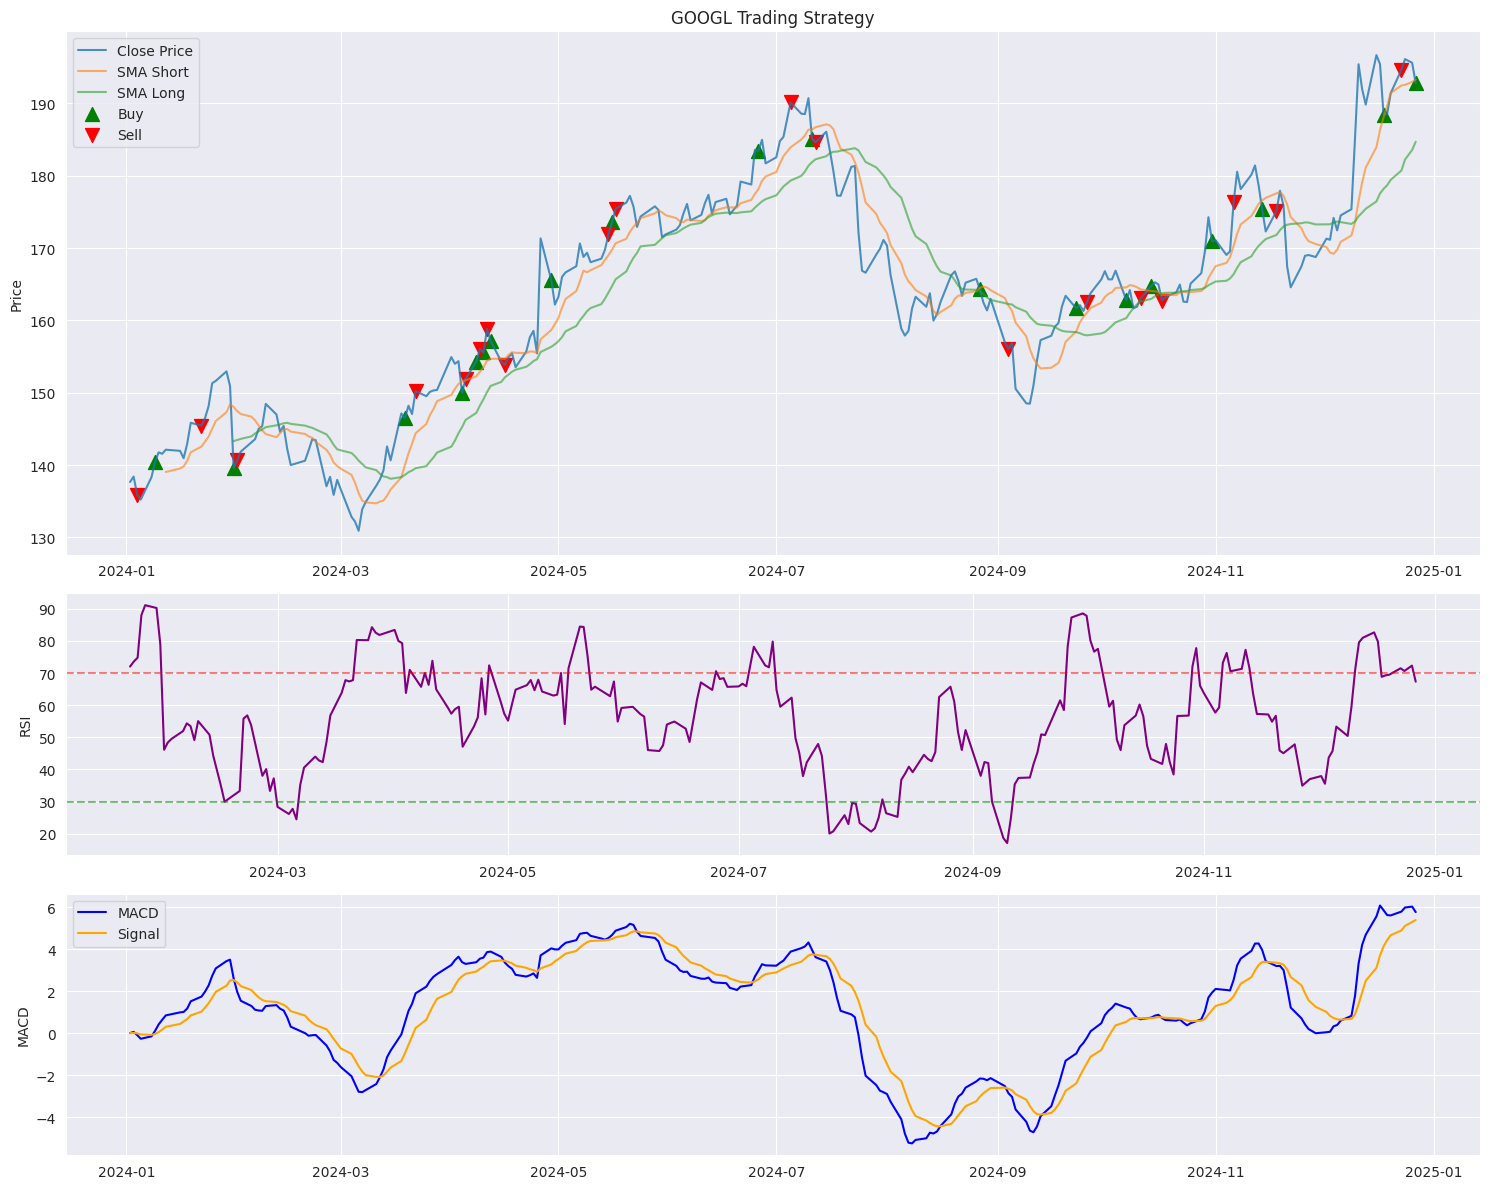

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class TradingStrategy:
    def __init__(self, symbol, start_date=None, end_date=None):
        self.symbol = symbol
        self.start_date = start_date or (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')

    def fetch_data(self):
        stock = yf.Ticker(self.symbol)
        data = stock.history(start=self.start_date, end=self.end_date, interval='1d')
        return data

    def generate_signals(self, data, short_window=9, long_window=21, rsi_period=14, rsi_upper=70, rsi_lower=30):
        df = data.copy()

        # Calculate SMAs
        df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
        df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        # Generate signals
        df['Signal'] = 0

        # Combined trading conditions
        buy_conditions = (
            (df['SMA_Short'] > df['SMA_Long']) &
            (df['RSI'] < rsi_lower) &
            (df['MACD'] > df['Signal_Line'])
        )

        sell_conditions = (
            (df['SMA_Short'] < df['SMA_Long']) |
            (df['RSI'] > rsi_upper) |
            (df['MACD'] < df['Signal_Line'])
        )

        df.loc[buy_conditions, 'Signal'] = 1
        df.loc[sell_conditions, 'Signal'] = -1
        df['Position'] = df['Signal'].diff()

        return df

    def plot_strategy(self, data):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])

        # Price and SMAs
        ax1.plot(data.index, data['Close'], label='Close Price', alpha=0.8)
        ax1.plot(data.index, data['SMA_Short'], label=f'SMA Short', alpha=0.6)
        ax1.plot(data.index, data['SMA_Long'], label=f'SMA Long', alpha=0.6)

        # Signals
        buy_signals = data[data['Position'] == 1]
        sell_signals = data[data['Position'] == -1]

        ax1.scatter(buy_signals.index, buy_signals['Close'],
                   marker='^', color='green', s=100, label='Buy')
        ax1.scatter(sell_signals.index, sell_signals['Close'],
                   marker='v', color='red', s=100, label='Sell')

        ax1.set_title(f'{self.symbol} Trading Strategy')
        ax1.set_ylabel('Price')
        ax1.grid(True)
        ax1.legend()

        # RSI
        ax2.plot(data.index, data['RSI'], color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
        ax2.set_ylabel('RSI')
        ax2.grid(True)

        # MACD
        ax3.plot(data.index, data['MACD'], label='MACD', color='blue')
        ax3.plot(data.index, data['Signal_Line'], label='Signal', color='orange')
        ax3.set_ylabel('MACD')
        ax3.grid(True)
        ax3.legend()

        plt.tight_layout()
        plt.show()

# Run strategy
symbol = 'GOOGL'
strategy = TradingStrategy(symbol)
data = strategy.fetch_data()
signals_df = strategy.generate_signals(data)
strategy.plot_strategy(signals_df)

Algorithm Implementation

Enter the stock symbol (e.g., AAPL, GOOGL):
Stock Symbol: JPM


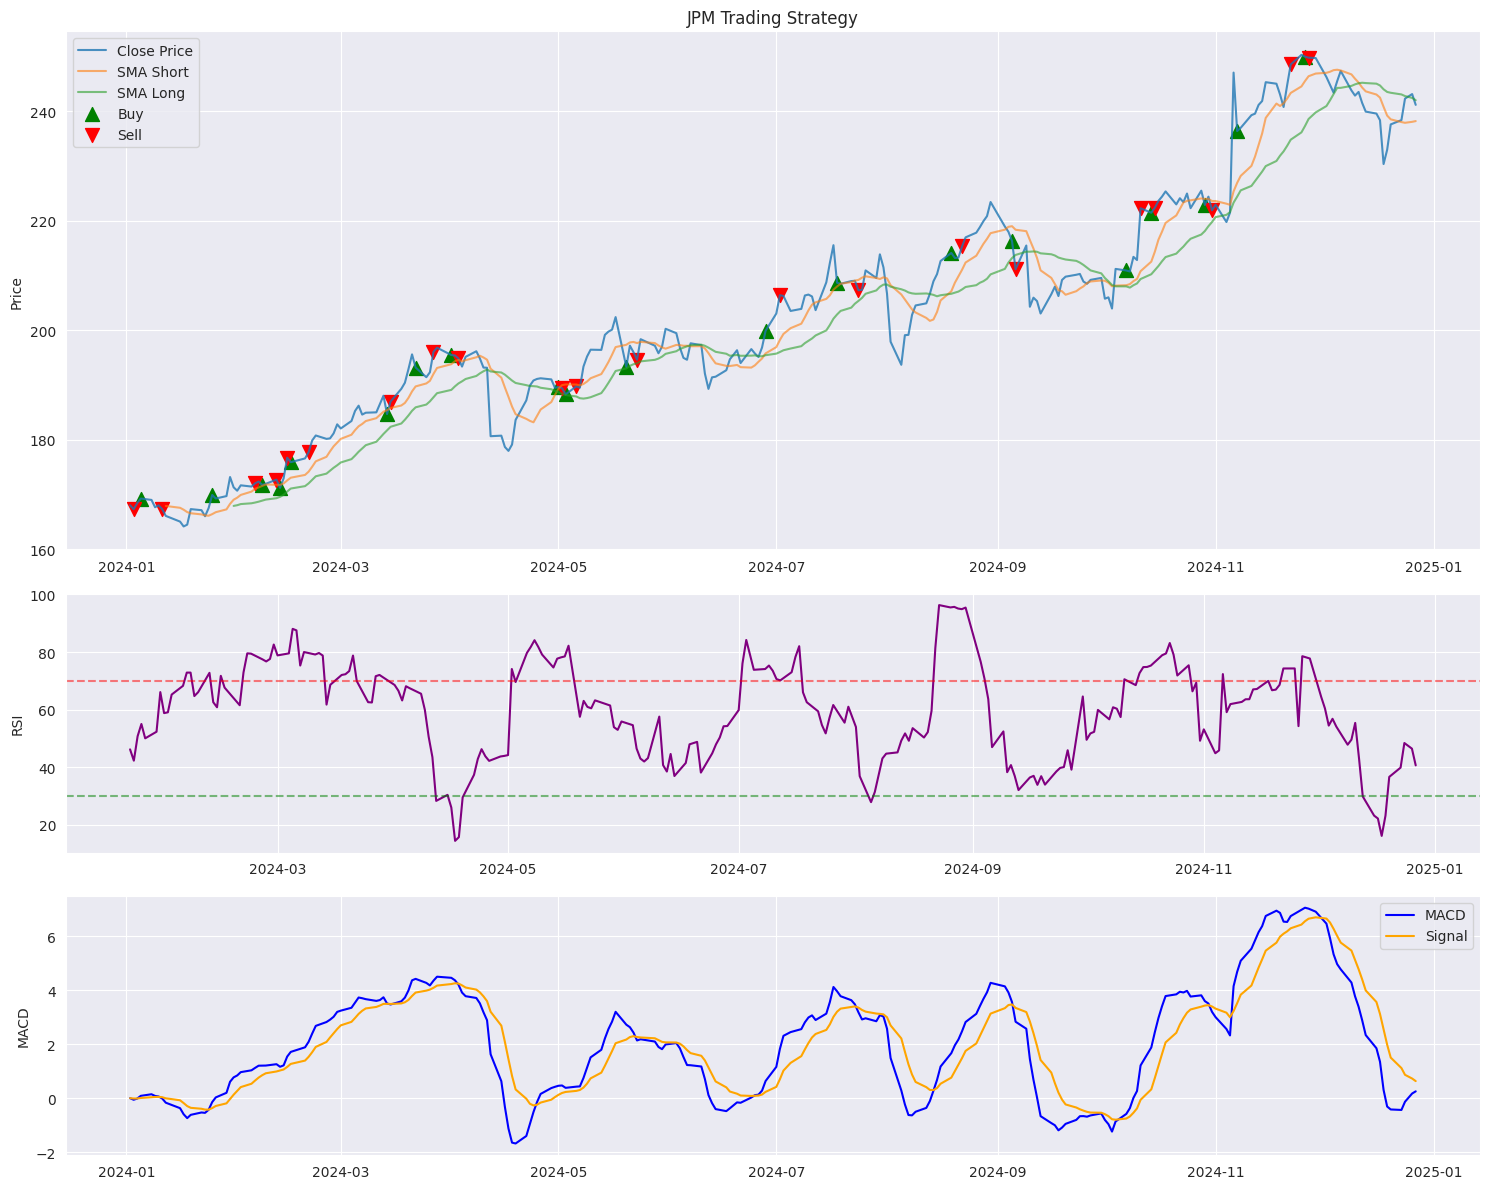


Trading Signals Explanation:
Buy Signal:
- Short-term SMA crosses above long-term SMA.
- RSI is below the oversold threshold (30).
- MACD line crosses above the Signal Line.

Sell Signal:
- Short-term SMA crosses below long-term SMA.
- RSI is above the overbought threshold (70).
- MACD line crosses below the Signal Line.

Buy Signals:
                                Close
Date                                 
2024-01-05 00:00:00-05:00  169.289749
2024-01-25 00:00:00-05:00  169.948166
2024-02-08 00:00:00-05:00  171.775970
2024-02-13 00:00:00-05:00  171.245316
2024-02-16 00:00:00-05:00  175.932785
2024-03-14 00:00:00-04:00  184.718140
2024-03-22 00:00:00-04:00  193.218475
2024-04-01 00:00:00-04:00  195.498352
2024-05-01 00:00:00-04:00  189.640625
2024-05-03 00:00:00-04:00  188.306229
2024-05-20 00:00:00-04:00  193.317581
2024-06-28 00:00:00-04:00  199.920319
2024-07-18 00:00:00-04:00  208.701065
2024-08-19 00:00:00-04:00  214.137756
2024-09-05 00:00:00-04:00  216.304489
2024-10-07 00:00

In [18]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class TradingStrategy:
    def __init__(self, symbol, start_date=None, end_date=None):
        self.symbol = symbol
        self.start_date = start_date or (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')

    def fetch_data(self):
        stock = yf.Ticker(self.symbol)
        data = stock.history(start=self.start_date, end=self.end_date, interval='1d')
        return data

    def generate_signals(self, data, short_window=9, long_window=21, rsi_period=14, rsi_upper=70, rsi_lower=30):
        df = data.copy()

        # Calculate SMAs
        df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
        df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        # Generate signals
        df['Signal'] = 0

        # Combined trading conditions
        buy_conditions = (
            (df['SMA_Short'] > df['SMA_Long']) &
            (df['RSI'] < rsi_lower) &
            (df['MACD'] > df['Signal_Line'])
        )

        sell_conditions = (
            (df['SMA_Short'] < df['SMA_Long']) |
            (df['RSI'] > rsi_upper) |
            (df['MACD'] < df['Signal_Line'])
        )

        df.loc[buy_conditions, 'Signal'] = 1
        df.loc[sell_conditions, 'Signal'] = -1
        df['Position'] = df['Signal'].diff()

        return df

    def plot_strategy(self, data):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])

        # Price and SMAs
        ax1.plot(data.index, data['Close'], label='Close Price', alpha=0.8)
        ax1.plot(data.index, data['SMA_Short'], label=f'SMA Short', alpha=0.6)
        ax1.plot(data.index, data['SMA_Long'], label=f'SMA Long', alpha=0.6)

        # Signals
        buy_signals = data[data['Position'] == 1]
        sell_signals = data[data['Position'] == -1]

        ax1.scatter(buy_signals.index, buy_signals['Close'],
                   marker='^', color='green', s=100, label='Buy')
        ax1.scatter(sell_signals.index, sell_signals['Close'],
                   marker='v', color='red', s=100, label='Sell')

        ax1.set_title(f'{self.symbol} Trading Strategy')
        ax1.set_ylabel('Price')
        ax1.grid(True)
        ax1.legend()

        # RSI
        ax2.plot(data.index, data['RSI'], color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
        ax2.set_ylabel('RSI')
        ax2.grid(True)

        # MACD
        ax3.plot(data.index, data['MACD'], label='MACD', color='blue')
        ax3.plot(data.index, data['Signal_Line'], label='Signal', color='orange')
        ax3.set_ylabel('MACD')
        ax3.grid(True)
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Explanation of signals
        print("\nTrading Signals Explanation:")
        print("Buy Signal:")
        print("- Short-term SMA crosses above long-term SMA.")
        print("- RSI is below the oversold threshold (30).")
        print("- MACD line crosses above the Signal Line.")
        print("\nSell Signal:")
        print("- Short-term SMA crosses below long-term SMA.")
        print("- RSI is above the overbought threshold (70).")
        print("- MACD line crosses below the Signal Line.")

        # Display dates and times for buy and sell signals
        print("\nBuy Signals:")
        print(data[data['Position'] == 1][['Close']])
        print("\nSell Signals:")
        print(data[data['Position'] == -1][['Close']])

# Interactive section for Google Colab
print("Enter the stock symbol (e.g., AAPL, GOOGL):")
symbol = input("Stock Symbol: ")

# Run strategy
strategy = TradingStrategy(symbol)
data = strategy.fetch_data()
signals_df = strategy.generate_signals(data)
strategy.plot_strategy(signals_df)


In [21]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

class TradingStrategy:
    def __init__(self, symbol, start_date=None, end_date=None):
        self.symbol = symbol
        self.start_date = start_date or (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')

    def fetch_data(self):
        stock = yf.Ticker(self.symbol)
        data = stock.history(start=self.start_date, end=self.end_date, interval='1d')
        return data

    def generate_signals(self, data, short_window=9, long_window=21, rsi_period=14, rsi_upper=70, rsi_lower=30):
        df = data.copy()

        # Calculate SMAs
        df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
        df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        # Generate signals
        df['Signal'] = 0

        # Combined trading conditions
        buy_conditions = (
            (df['SMA_Short'] > df['SMA_Long']) &
            (df['RSI'] < rsi_lower) &
            (df['MACD'] > df['Signal_Line'])
        )

        sell_conditions = (
            (df['SMA_Short'] < df['SMA_Long']) |
            (df['RSI'] > rsi_upper) |
            (df['MACD'] < df['Signal_Line'])
        )

        df.loc[buy_conditions, 'Signal'] = 1
        df.loc[sell_conditions, 'Signal'] = -1
        df['Position'] = df['Signal'].diff()

        return df

    def plot_strategy(self, data):
        buy_signals = data[data['Position'] == 1]
        sell_signals = data[data['Position'] == -1]

        # Plotly Figure
        fig = go.Figure()

        # Add candlestick chart
        fig.add_trace(go.Candlestick(
            x=data.index,
            open=data['Open'],
            high=data['High'],
            low=data['Low'],
            close=data['Close'],
            name='Candlestick'))

        # Add SMA lines
        fig.add_trace(go.Scatter(x=data.index, y=data['SMA_Short'], mode='lines', name='SMA Short'))
        fig.add_trace(go.Scatter(x=data.index, y=data['SMA_Long'], mode='lines', name='SMA Long'))

        # Add Buy signals
        fig.add_trace(go.Scatter(
            x=buy_signals.index,
            y=buy_signals['Close'],
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='Buy Signal'))

        # Add Sell signals
        fig.add_trace(go.Scatter(
            x=sell_signals.index,
            y=sell_signals['Close'],
            mode='markers',
            marker=dict(color='red', size=10, symbol='triangle-down'),
            name='Sell Signal'))

        # Layout
        fig.update_layout(
            title=f'{self.symbol} Trading Strategy',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_dark',
            legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

        fig.show()

        # Explanation of signals
        print("\nTrading Signals Explanation:")
        print("Buy Signal:")
        print("- Short-term SMA crosses above long-term SMA.")
        print("- RSI is below the oversold threshold (30).")
        print("- MACD line crosses above the Signal Line.")
        print("\nSell Signal:")
        print("- Short-term SMA crosses below long-term SMA.")
        print("- RSI is above the overbought threshold (70).")
        print("- MACD line crosses below the Signal Line.")

        # Display dates and times for buy and sell signals
        print("\nBuy Signals:")
        print(buy_signals[['Close']])
        print("\nSell Signals:")
        print(sell_signals[['Close']])

# Interactive section for Google Colab
print("Enter the stock symbol (e.g., AAPL, GOOGL):")
symbol = input("Stock Symbol: ")

# Run strategy
strategy = TradingStrategy(symbol)
data = strategy.fetch_data()
signals_df = strategy.generate_signals(data)
strategy.plot_strategy(signals_df)


Enter the stock symbol (e.g., AAPL, GOOGL):
Stock Symbol: MSFT



Trading Signals Explanation:
Buy Signal:
- Short-term SMA crosses above long-term SMA.
- RSI is below the oversold threshold (30).
- MACD line crosses above the Signal Line.

Sell Signal:
- Short-term SMA crosses below long-term SMA.
- RSI is above the overbought threshold (70).
- MACD line crosses below the Signal Line.

Buy Signals:
                                Close
Date                                 
2024-01-08 00:00:00-05:00  372.653351
2024-01-31 00:00:00-05:00  395.418915
2024-02-05 00:00:00-05:00  403.445038
2024-03-14 00:00:00-04:00  423.690735
2024-05-13 00:00:00-04:00  412.232086
2024-05-30 00:00:00-04:00  413.923950
2024-06-13 00:00:00-04:00  440.785522
2024-07-09 00:00:00-04:00  458.713226
2024-08-21 00:00:00-04:00  424.140015
2024-08-26 00:00:00-04:00  413.489990
2024-09-16 00:00:00-04:00  431.339996
2024-09-24 00:00:00-04:00  429.170013
2024-09-27 00:00:00-04:00  428.019989
2024-10-24 00:00:00-04:00  424.730011
2024-10-28 00:00:00-04:00  426.589996
2024-11-29 00:00